# 2023-09-13 · Clippin and Ceilin

In [1]:
include("lib/Nto1.jl")

using Revise … ✔ (0.5 s)
using Units, Nto1AdEx, ConnectionTests, ConnTestEval, MemDiskCache … ✔ (1.0 s)
using StatsBase … ✔ (0.4 s)


In [2]:
N = 6500
duration = 10minutes

@time sim = Nto1AdEx.sim(N, duration, ceil_spikes = false);

  4.950523 seconds (2.14 M allocations: 1.026 GiB, 2.04% gc time, 43.66% compilation time)


(Hm, spikerate not 4.0 Hz (even though we use our lookup table))

In [3]:
sim.spikerate / Hz

4.7

## Ceil

In [4]:
V_no_ceil = sim.V;
V_ceil = ceil_spikes!(copy(V_no_ceil), sim.spiketimes);  # V_ceil = Vₛ = 
Nto1AdEx.Vₛ / mV

40

In [5]:
include("lib/plot.jl")

import PythonCall … ✔ (4 s)
import PythonPlot … ✔ (9.5 s)
using Sciplotlib … [ Info: Precompiling Sciplotlib [88be95e5-9550-4d5f-a203-92a5acbc3118]
✔ (9.5 s)
using PhDPlots … [ Info: Precompiling PhDPlots [8882fb83-7a18-4ae0-b3ef-a58e1f4042a1]
✔ (4.7 s)


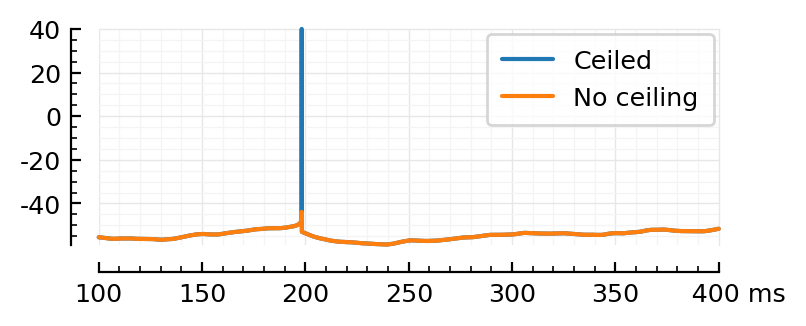

In [6]:
fig, ax = plt.subplots(figsize=(4, 1.4))
plotsig(V_ceil / mV,    [100, 400], ms, label="Ceiled")
plotsig(V_no_ceil / mV, [100, 400], ms, label="No ceiling")
legend(ax, reverse=false);

## Clip

And now for the clipping, we do it data driven (i.e. no explicit spike detection), just a percentile.

In [7]:
include("lib/df.jl")

using DataFrames … ✔ (1.5 s)


In [8]:
set_print_precision(4)
ENV["DATAFRAMES_ROWS"] = 12;

In [9]:
ps = [0, 0.1, 1, 5, 10, 50, 90, 95, 99, 99.9, 99.95, 99.99, 100]
qs = percentile(V_ceil, ps)
df = DataFrame("p" => ps, "V (mV)" => qs/mV)
showsimple(df)

 p       V (mV) 
────────────────
   0     -65
   0.1   -58.75
   1     -58.07
   5     -57.37
  10     -56.91
  50     -53.98
  90     -51.6
  95     -51.06
  99     -49.79
  99.9   -46.77
  99.95  -44.24
  99.99   40
 100      40

In [11]:
df_ = permutedims(df, "p", strict=false)
showsimple(df_, allcols=true)

 p       0.0  0.1     1.0     5.0     10.0    50.0    90.0   95.0    99.0    99.9    99.95   99.99  100.0 
──────────────────────────────────────────────────────────────────────────────────────────────────────────
 V (mV)  -65  -58.75  -58.07  -57.37  -56.91  -53.98  -51.6  -51.06  -49.79  -46.77  -44.24  40     40

Okay, lesgo for 99.

In [12]:
clip!(V, p = 99) = begin
    V_thr = percentile(V, p)
    to_clip = V .≥ V_thr
    V[to_clip] .= V_thr
    V
end

V_ceil_n_clip = clip!(copy(V_ceil));

In [13]:
Vs = [
    (V = V_no_ceil,     label = "No ceiling",       zorder = 2),
    (V = V_ceil,        label = "Ceiled spikes",    zorder = 1),
    (V = V_ceil_n_clip, label = "Ceiled & Clipped", zorder = 3),
];

Saved at `../thesis/figs/ceil_n_clip_sigs.pdf`

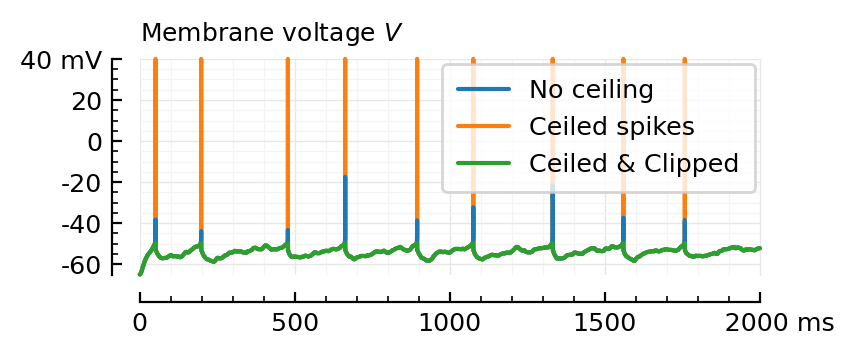

In [14]:
fig, ax = plt.subplots(figsize=(4, 1.4))
for (V, label, zorder) in Vs
    plotsig(V, [0, 2000], ms; label, zorder, yunit=:mV)
end
hylabel(ax, L"Membrane voltage $V$")
legend(ax)
# savefig_phd("ceil_n_clip_sigs")

## STAs

In [15]:
exc_input_1 = highest_firing(excitatory_inputs(sim))[1]

SpikeTrain(58522 spikes, 97.54 Hz, [0.004668, 0.01482, 0.04501, 0.04727, 0.05836, 0.07584, 0.0927, 0.1063, 0.1094, 0.1099  …  599.9, 600, 600, 600, 600, 600, 600, 600, 600, 600])

In [16]:
ConnectionTests.set_STA_length(100ms);

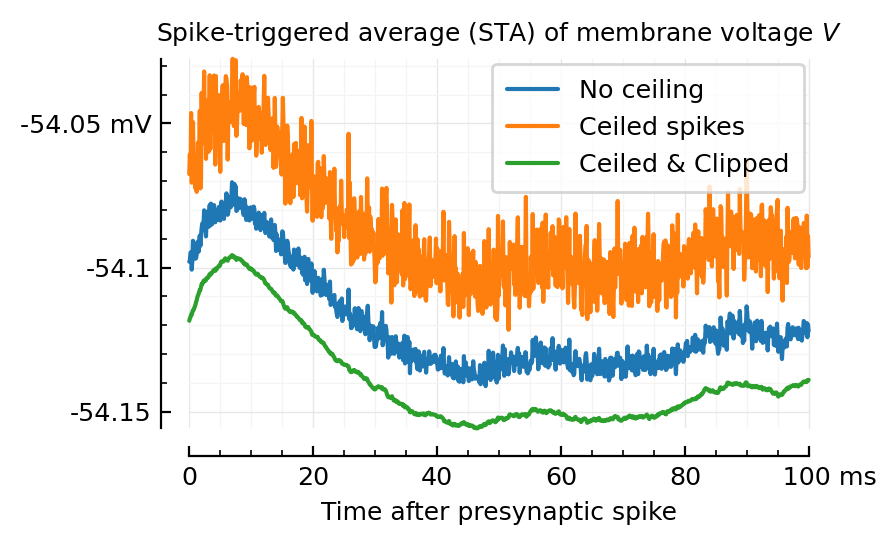

In [18]:
fig, ax = plt.subplots()
# set(ax, ylim=[-54.1601, -54.02])  # grr (no work)
for (V, label, zorder) in Vs
    STA = calc_STA(V, exc_input_1.times)
    plotSTA(STA; label, nbins_y=4, hylabel=nothing)
end
hylabel(ax, L"Spike-triggered average (STA) of membrane voltage $V$", loc="center")
legend(ax);
# savefig_phd("ceil_n_clip_STAs")

Interesting! They have diff base heights (very convenient for plotting on same ax, here).

Ok, it makes sense. They're averages: each sample dragged down or up.

## ROCs

In [19]:
trains_to_test = get_trains_to_test(sim);

In [20]:
ConnectionTests.set_STA_length(20ms);

In [21]:
function test_conns(V)
    test(train) = test_conn(STAHeight(), V, train.times)
    rows = []
    for (conntype, trains) in trains_to_test
        descr = string(conntype)
        @showprogress descr for train in trains
            t = test(train)
            fr = spikerate(train)
            push!(rows, (; conntype, fr, t))
        end
    end
    DataFrame(rows)
end;

In [22]:
MemDiskCache.set_dir("2023-09-13__Clippin_and_Ceilin")

"C:\\Users\\tfiers\\.julia\\MemDiskCache.jl\\2023-09-13__Clippin_and_Ceilin"

In [23]:
df_no_ceil     = @cached test_conns(V_no_ceil);      # 55.6 seconds

Loading [C:\Users\tfiers\.julia\MemDiskCache.jl\2023-09-13__Clippin_and_Ceilin\test_conns(V_no_ceil).jld2] … ✔ (3.9 s)


In [24]:
df_ceil        = @cached test_conns(V_ceil);         # 51.3 seconds

Loading [C:\Users\tfiers\.julia\MemDiskCache.jl\2023-09-13__Clippin_and_Ceilin\test_conns(V_ceil).jld2] … ✔


In [25]:
df_ceil_n_clip = @cached test_conns(V_ceil_n_clip);  # 51.8 seconds

Loading [C:\Users\tfiers\.julia\MemDiskCache.jl\2023-09-13__Clippin_and_Ceilin\test_conns(V_ceil_n_clip).jld2] … ✔


In [26]:
dfs = [df_no_ceil, df_ceil, df_ceil_n_clip];
sweeps = sweep_threshold.(dfs)
AUCs = calc_AUROCs.(sweeps);

In [27]:
labels = extract(:label, Vs);

In [28]:
df = DataFrame(AUCs)
insertcols!(df, 1, :V_type=>labels)
showsimple(df)

 V_type            AUC     AUCₑ    AUCᵢ   
──────────────────────────────────────────
 No ceiling        0.7485  0.6617  0.8354
 Ceiled spikes     0.5632  0.4909  0.6354
 Ceiled & Clipped  0.7874  0.6912  0.8836

Distilling from [mpl docs' Examples: Grouped bar chart with labels](https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html):

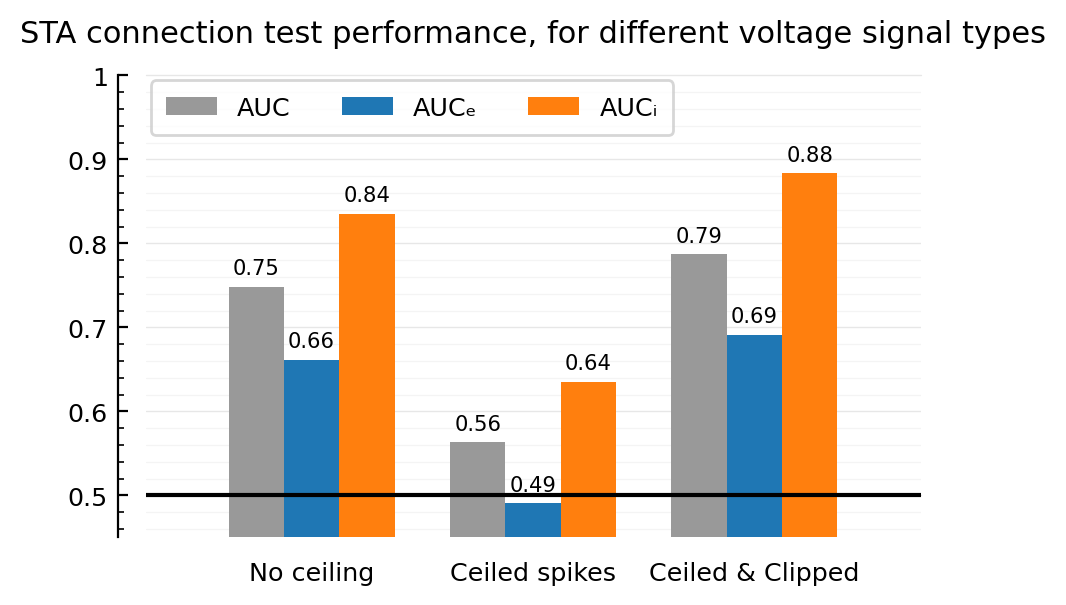

In [29]:
function grouped_barplot(df; cols, group_labels, ax=nothing, bar_label_fmt="%.2g", colors=nothing, kw...)
    N_groups = length(group_labels)
    N_bars_per_group = length(cols)
    if isnothing(ax)
        fig, ax = plt.subplots()
    end
    if isnothing(colors)
        colors = mplcolors[1:N_bars_per_group]
    end
    x = 0:(N_groups - 1)
    width = 1/(N_bars_per_group + 1)
    for (i, (colname, color)) in enumerate(zip(cols, colors))
        values = df[!, colname]
        offset = (i-1) * width
        bars = ax.bar(x .+ offset, values, width, label=colname, color=toRGBAtuple(color))
        ax.bar_label(bars, padding = 3, fmt=bar_label_fmt, fontsize="x-small")
    end
    set(ax, xtype=:categorical)
    ax.set_xticks(x .+ width, group_labels)
    return ax
end

fig, ax = plt.subplots(figsize=(5, 3))
ax.axhline(0.5, color="black")
colors = [color_both, color_exc, color_inh]
ax = grouped_barplot(df, cols=["AUC", "AUCₑ", "AUCᵢ"], group_labels=df.V_type; ax, colors);
legend(ax, ncols=3, loc="upper left")
set(ax, ylim=[0.45, 1], xtype=:keep, title="""
    STA connection test performance, for different voltage signal types""");
# savefig_phd("ceil_n_clip_AUCs")

## Threshold-plot

Visualize what ROC is.

In [30]:
sweep = sweep_threshold(df_ceil_n_clip);

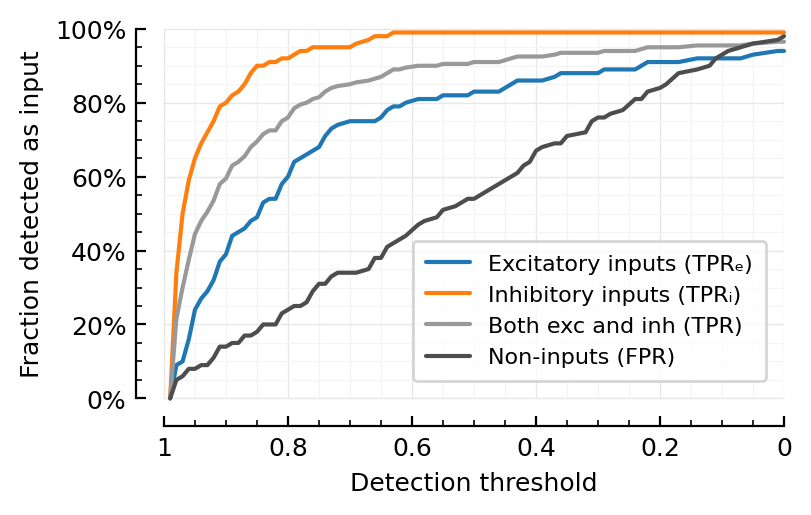

In [356]:
function plot_perfmeasures_threshold_TPRs(ax=newax())
    plot(sweep.threshold, sweep.TPRₑ; color=color_exc, label="Excitatory inputs (TPRₑ)", ax)
    plot(sweep.threshold, sweep.TPRᵢ; color=color_inh, label="Inhibitory inputs (TPRᵢ)", ax)
    plot(sweep.threshold, sweep.TPR; color=color_both, label="Both exc and inh (TPR)", ax)
    plot(sweep.threshold, sweep.FPR; color=color_unconn, label="Non-inputs (FPR)", ax)
    set(ax, ytype=:fraction, ylabel="Fraction detected as input", xlabel="Detection threshold")
    ax.invert_xaxis()
    legend(ax)
end
plot_perfmeasures_threshold_TPRs();

In [573]:
function deemph_middle_ticks(x, black = 0.24)
    if isinstance(x, plt.Figure)
        for ax in x.axes
            deemph_middle_ticks(ax, black)
        end
    elseif isinstance(x, plt.Axes)
        deemph_middle_ticks(x.xaxis, black)
        deemph_middle_ticks(x.yaxis, black)
    else
        _deemph_middle_ticks(x, black)
    end
    x
end

isinstance(x, T) = pyconvert(Bool, pybuiltins.isinstance(x, T))

function _deemph_middle_ticks(axis, black)
    color = as_mpl_type(Gray(1 - black))
    ticklabels = pyconvert(Vector, axis.get_ticklabels())
    N = length(ticklabels)
    N_to_deemph = length(ticklabels) - 2
    N_to_deemph > 0 || return
    for t in ticklabels[2:end-1]
        t.set_color(color)
    end
    ticks = get_ticks(axis)
    N = length(axis.get_ticklocs())
    major_ticks = ticks[1:N]
    minor_ticks = ticks[(N+1):end]
    for t in major_ticks[2:end-1]
        t._apply_params(; color)  # Thx https://stackoverflow.com/a/33698352/2611913
    end
    for t in minor_ticks
        t._apply_params(; color)
    end
end

get_ticks(axis) = filter!(x -> isinstance(x, mpl.axis.Tick), pyconvert(Vector, axis.get_children()))

nothing

Saved at `../thesis/figs/perfmeasures_θ_TPR_ROC.pdf`

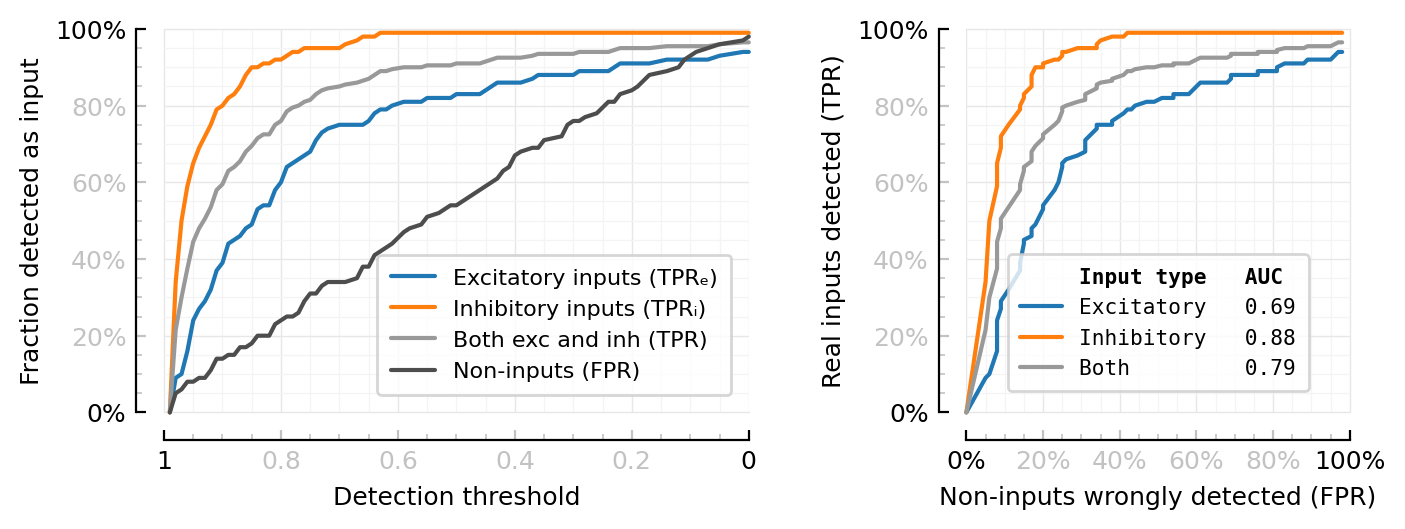

In [574]:
set_bbox("tight")

fig, axs = plt.subplots(ncols=2, figsize=(pw, 0.3pw))
# fig.set_facecolor("aliceblue")
plot_perfmeasures_threshold_TPRs(axs[0])
plotROC(sweep; ax=axs[1])
deemph_middle_ticks(fig);
savefig_phd("perfmeasures_θ_TPR_ROC")

In [575]:
print_size_info(fig)

Given size:  (8.3, 2.49), aspect: 3.33
Output size: (7.02, 2.64), aspect: 2.66


Saved at `../thesis/figs/temp__ROC.pdf`

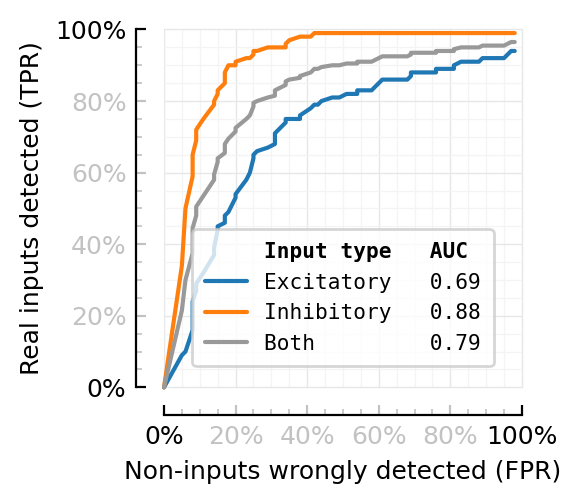

In [576]:
set_bbox("tight")

fig, ax = plt.subplots(figsize=(mw,mw))
# fig.set_facecolor("aliceblue")
plotROC(sweep; ax);
deemph_middle_ticks(fig);
savefig_phd("temp__ROC")

In [577]:
print_size_info(fig)

Given size:  (2.32, 2.32), aspect: 1
Output size: (2.88, 2.52), aspect: 1.14


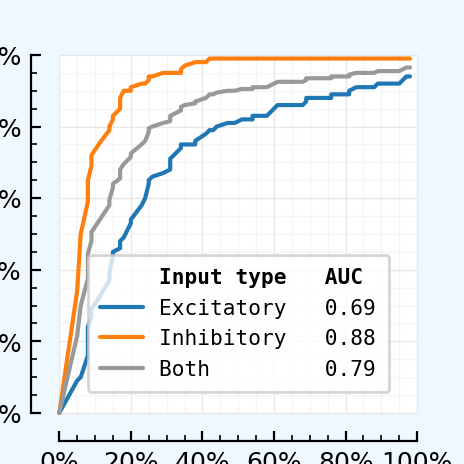

In [578]:
set_bbox("standard")

fig, ax = plt.subplots(figsize=(mw,mw))
fig.set_facecolor("aliceblue")
plotROC(sweep; ax);
# savefig_phd("temp__ROC")

In [579]:
print_size_info(fig)

Given size:  (2.32, 2.32), aspect: 1
Output size: (2.32, 2.32), aspect: 1


## Precision & F-scores

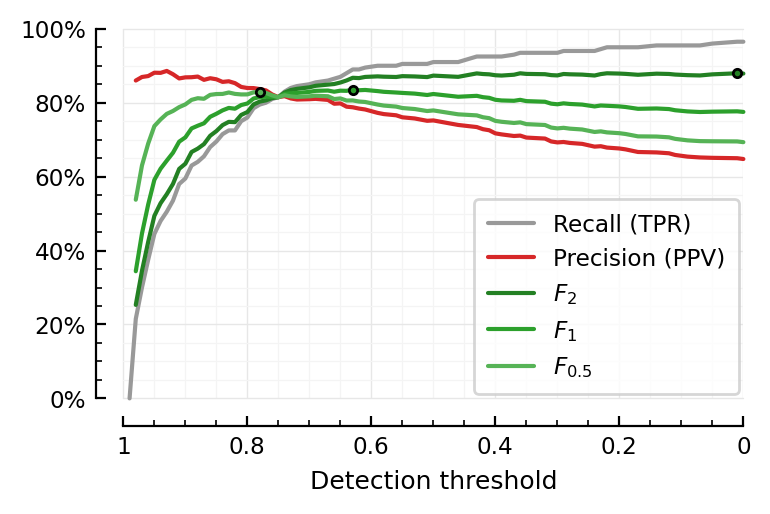

In [671]:
function plot_perfmeasures_Fscores(ax=newax())
    
    plot(sweep.threshold, sweep.TPR, color=color_both,  label="Recall (TPR)")
    plot(sweep.threshold, sweep.PPV, color=C3,          label="Precision (PPV)")

    for (series, color, label) in [
            (sweep.F2,  darken(C2),  L"F_2"),
            (sweep.F1,  C2,          L"F_1"),
            (sweep.F05, lighten(C2), L"F_{0.5}"),
        ]
        plot(sweep.threshold, series; color, label)
        i = argmax(skipnan(series))
        plot(sweep.threshold[i], series[i], "."; color, mec="black")
    end
    set(ax, ytype=:fraction, xlabel="Detection threshold")
    ax.invert_xaxis()
    legend(ax)
    # label_lines(ax, yoffset=[2=>-0.02])
end
plot_perfmeasures_Fscores();

In [109]:
using PythonCall: pyconvert
function label_lines(ax; yoffset=[])
    offsets = Dict(offsets)
    for (i, line) in enumerate(ax.lines)
        x,y = pyconvert(NTuple{2,Vector{Float64}}, line.get_data())
        s = pyconvert(String, line.get_label())
        dy = get(offset, i, 0)
        ax.text(x[end], y[end]+dy, " $s", color=line.get_color(), va="center", fontsize="small")
    end
end;
# Very cool.
# Not using now though :)  Just the normal legend.
# 
# To possibly add: allow specifying offset in axes coords;
# so need to add to diff transforms (I did this before for sth else).

Where is F1 maximal?

PR curve (analogous to ROC):

(note, in ROC, recall (TPR) is on y; here it's on x)

"Out of all that's predicted [inh], how many actually are".

## Iso-Fβ curves

Iso-Fβ curves :)  (msc throwback).

So, a formula to isolate precision from F formula.

$$
\begin{align}
%
F &= (1+β^2) \frac{P R}{β^2  P + R}  \\[3em]
%
(β^2  P + R) F &= (1+β^2 ) P R  \\[0.8em]
%
β^2  P F + R F &= PR + β^2 PR  \\[0.8em]
%
β^2 PF - PR - β^2 PR &= -RF  \\[0.8em]
%
P &= \frac{-RF}{β^2 F - R - β^2 R}  \\[3em]
%
P &= \frac{R F}{(1 + β^2) R - β^2 F}
%
\end{align}
$$

In [651]:
⪅(x,y) = (x < y) || x ≈ y;

In [652]:
precision(recall, F; β) = begin
    P = (
            (recall * F)
                /
        ( (1+β^2)*recall - β^2*F )
    )
    return (0 ⪅ P ⪅ 1) ? P : NaN
end;

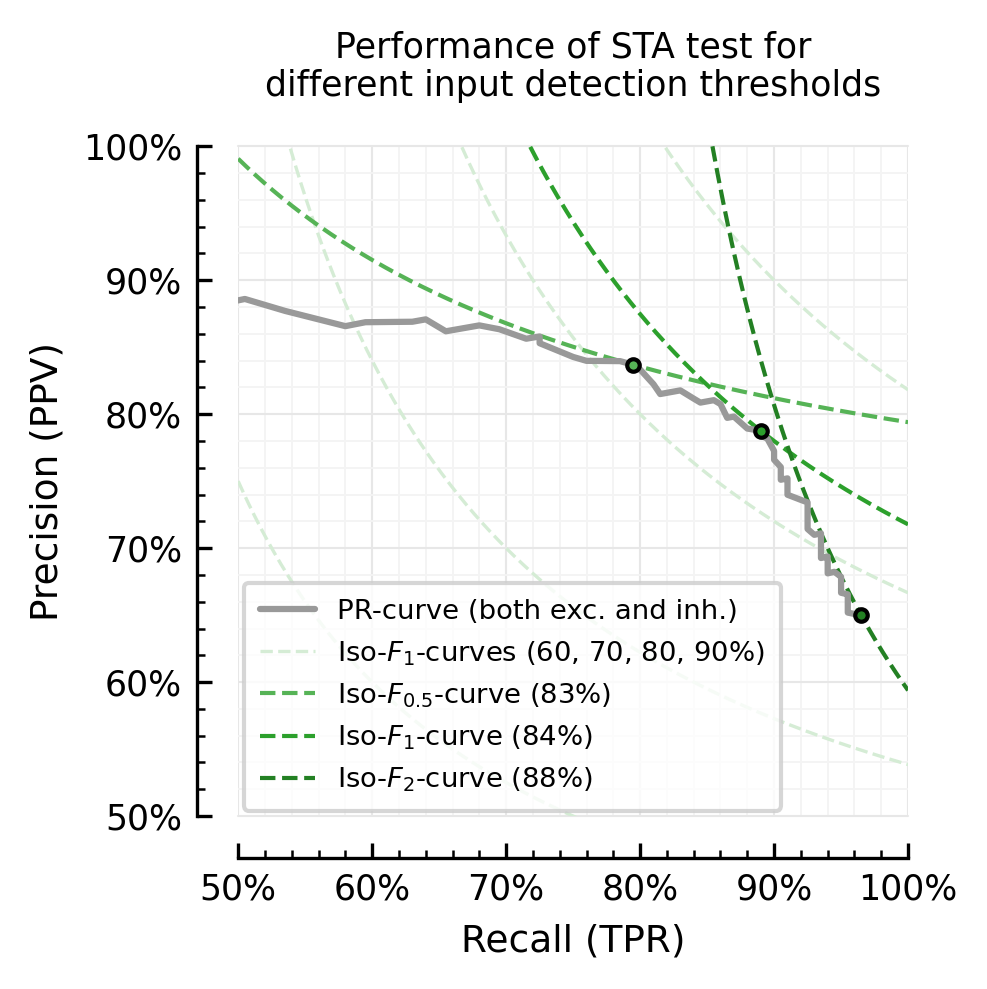

In [672]:
function plot_perfmeasures_PR_curves_iso_Fβ(ax)
    
    plot(sweep.TPR,  sweep.PPV ; color=color_both, ax, label="PR-curve (both exc. and inh.)", clip_on=true)

    x0 = 0.5
    R = x0:(1/1000):1

    Fs = [0.6, 0.7, 0.8, 0.9]
    Fs_str = join(100*Fs, ", ") * "%"
    for (i,F) in enumerate(Fs)
        label = (i > 1) ? nothing : L"Iso-$F_1$-curves (%$Fs_str)"
        plot(R, precision.(R, F; β=1); color=lighten(C2,0.2), lw=0.8, ls="--", clip_on=true, zorder=1, label)
    end

    for (β, series, color) in [
            (β=0.5, series=sweep.F05, color= lighten(C2)),
            (β=1,   series=sweep.F1,  color=identity(C2)),
            (β=2,   series=sweep.F2,  color=  darken(C2)),
        ]
        F, i = findmax(skipnan(series))
        label=L"Iso-$F_{%$β}$-curve (%$(round(100*F))%)"
        plot(R, precision.(R, F; β);      color, lw=1, ls="--", label, clip_on=true, zorder=1)
        plot(sweep.recall[i], sweep.precision[i], "."; mec="black", mfc=color, zorder=2)
    end

    set(ax, aspect="equal", xtype=:fraction, ytype=:fraction,
        xlabel="Recall (TPR)", ylabel="Precision (PPV)",
        xlim=[x0, 1], ylim=[x0, 1],
        title=("""
            Performance of STA test for
            different input detection thresholds""", :fontsize=>"small"))
    legend(ax, fontsize=6.6, loc="lower left")
end

fig, ax = plt.subplots(figsize=(2.9,2.9), dpi=300)
plot_perfmeasures_PR_curves_iso_Fβ(ax);

We don't want too many `R` points (for smaller fig filesize).\
We wanna know where `precision(R)` == 1.\
(To selectively add these points to our x (R) linspace :). For nice near-asympote plotting).\
I.e. solve: R = ...

Picking up from above and continuing (on a diff branch):
$$
\begin{align}
%
β^2 P F  &=  PR + β^2 PR - R F \\[0.8em]
%
R &= \frac{β^2 P F}{P + β^2 P - F}\\[0.8em]
%
R &= \frac{β^2 P F}{(1 + β^2)P - F}\\[0.8em]
%
\end{align}
$$

In [653]:
recall(precision, F; β) = begin
    R = (
            (β^2 * precision * F)
                /
        ( (1+β^2)*precision - F )
    )
    return (0 ⪅ R ⪅ 1) ? R : NaN
end;

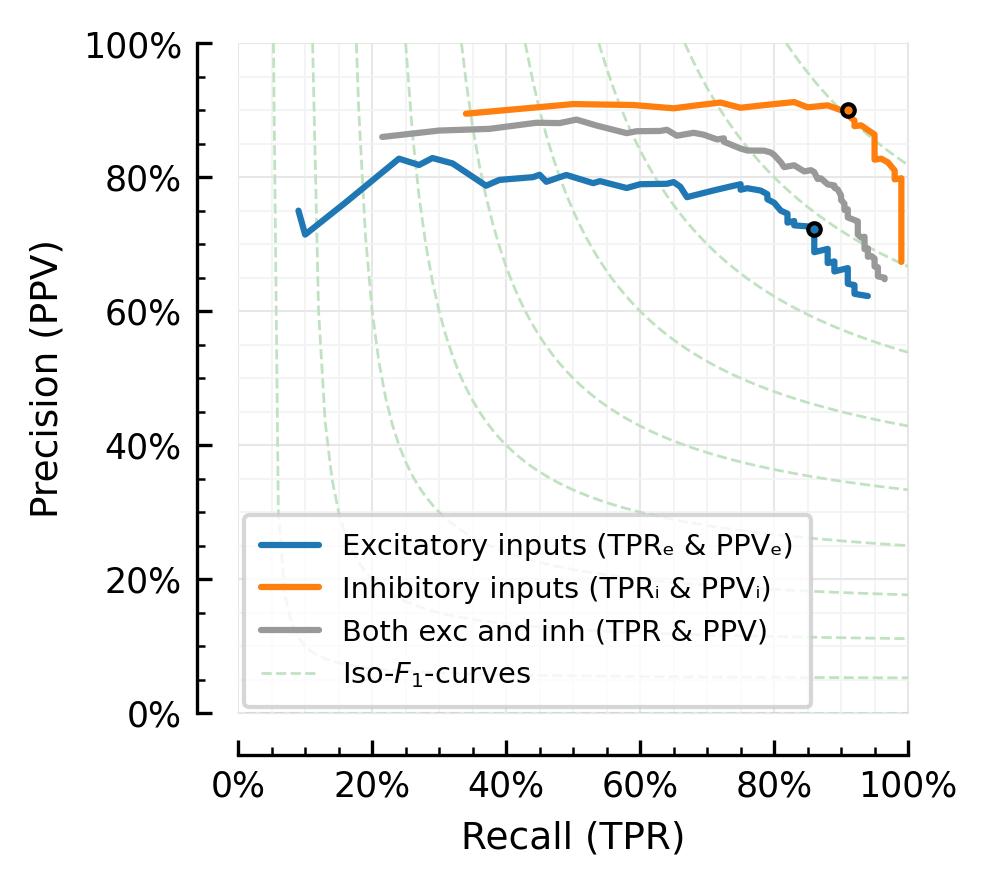

In [674]:
function plot_perfmeasures_PR_curves_EI(ax)

    plot(sweep.TPRₑ, sweep.PPVₑ; color=color_exc,  ax, label="Excitatory inputs (TPRₑ & PPVₑ)")
    plot(sweep.TPRᵢ, sweep.PPVᵢ; color=color_inh,  ax, label="Inhibitory inputs (TPRᵢ & PPVᵢ)")
    plot(sweep.TPR,  sweep.PPV ; color=color_both, ax, label="Both exc and inh (TPR & PPV)")

    iₑ = argmax(skipnan(sweep.F1ₑ))
    plot(sweep.TPRₑ[iₑ], sweep.PPVₑ[iₑ], "."; color=color_exc, mec="black")

    iᵢ = argmax(skipnan(sweep.F1ᵢ))
    plot(sweep.TPRᵢ[iᵢ], sweep.PPVᵢ[iᵢ], "."; color=color_inh, mec="black")

    β = 1
    Fs = 0:0.1:1
    R = 0:(1/100):1
    extra_Rs = recall.(1, Fs; β)
    R = sort!([R..., extra_Rs...])
    for (i,F) in enumerate(Fs)
        label = (i > 1) ? nothing : L"Iso-$F_1$-curves"
        P = precision.(R, F; β)
        plot(R, P; color=lighten(C2, 0.3), lw=0.66, ls="--", clip_on=true, zorder=1, label)
    end

    set(ax, aspect="equal", xtype=:fraction, ytype=:fraction,
         xlabel="Recall (TPR)", ylabel="Precision (PPV)")

    legend(ax, fontsize="x-small", loc="lower left")
end
    
fig, ax = plt.subplots(figsize=(2.9,2.9), dpi=300)
plot_perfmeasures_PR_curves_EI(ax);

## Two thresholds?

"Do we need two thresholds?" i.e. one for exc and one for inh. (pfrt)

In [458]:
deemph_(t, color="gray") = t.set_color("gray")
legend_label_texts(ax) = pyconvert(Vector, ax.legend_.get_texts());

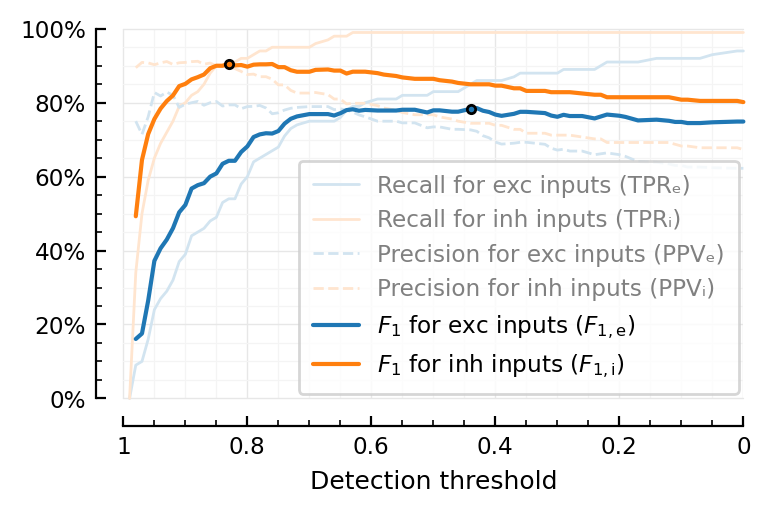

In [676]:
function plot_perfmeasures_threshold_PPVs_EI(ax=newax())
    θ = sweep.threshold
    plot(θ, sweep.TPRₑ; color=lighten(color_exc,.2), lw=1, ax, label="Recall for exc inputs (TPRₑ)")
    plot(θ, sweep.TPRᵢ; color=lighten(color_inh,.2), lw=1, ax, label="Recall for inh inputs (TPRᵢ)")
    plot(θ, sweep.PPVₑ; color=lighten(color_exc,.2), lw=1, ax, label="Precision for exc inputs (PPVₑ)", ls="--")
    plot(θ, sweep.PPVᵢ; color=lighten(color_inh,.2), lw=1, ax, label="Precision for inh inputs (PPVᵢ)", ls="--")
    plot(θ, sweep.F1ₑ; color=color_exc, ax, label=L"$F_1$ for exc inputs ($F_{1,\mathrm{e}}$)")
    plot(θ, sweep.F1ᵢ; color=color_inh, ax, label=L"$F_1$ for inh inputs ($F_{1,\mathrm{i}}$)")

    iₑ = argmax(filter(!isnan, sweep.F1ₑ))
    plot(θ[iₑ], sweep.F1ₑ[iₑ], "."; color=color_exc, mec="black")

    iᵢ = argmax(skipnan(sweep.F1ᵢ))
    plot(θ[iᵢ], sweep.F1ᵢ[iᵢ], "."; color=color_inh, mec="black")

    set(ax, ytype=:fraction, xlabel="Detection threshold")
    ax.invert_xaxis()
    legend(ax);
    deemph_.(legend_label_texts(ax)[1:4])
end

plot_perfmeasures_threshold_PPVs_EI();

## STA examples plot

(repeat of `2023-08-30__STA_examples`, but now with clipped spikes, i.e. cleaner; and what we -- in the end -- actually use for the conntests :)).

In [523]:
V = V_ceil_n_clip

exc_inputs = highest_firing(excitatory_inputs(sim))
inh_inputs = highest_firing(inhibitory_inputs(sim))

mid = length(exc_inputs) ÷ 2

plotSTA_(train; hylabel=nothing, xlim=[0,100], kw...) = begin
    n = num_spikes(train)
    if n ≥ 1000
        n = string(round(Int, n / 1000)) * "k"
    end
    r = round(spikerate(train), sigdigits=2)
    if isinteger(r)
        r = Int(r)
    end
    r = "$(lpad(r,2)) Hz"
    exc_or_inh = (train ∈ exc_inputs) ? "exc" : "inh"
    label = "$(rpad(r, 6)) | $(lpad(n,3)) spikes | $exc_or_inh"
    plotSTA(calc_STA(V, train.times); label, hylabel, xlim, nbins_y=3, kw...)
end;

Saved at `../thesis/figs/example_STAs.pdf`

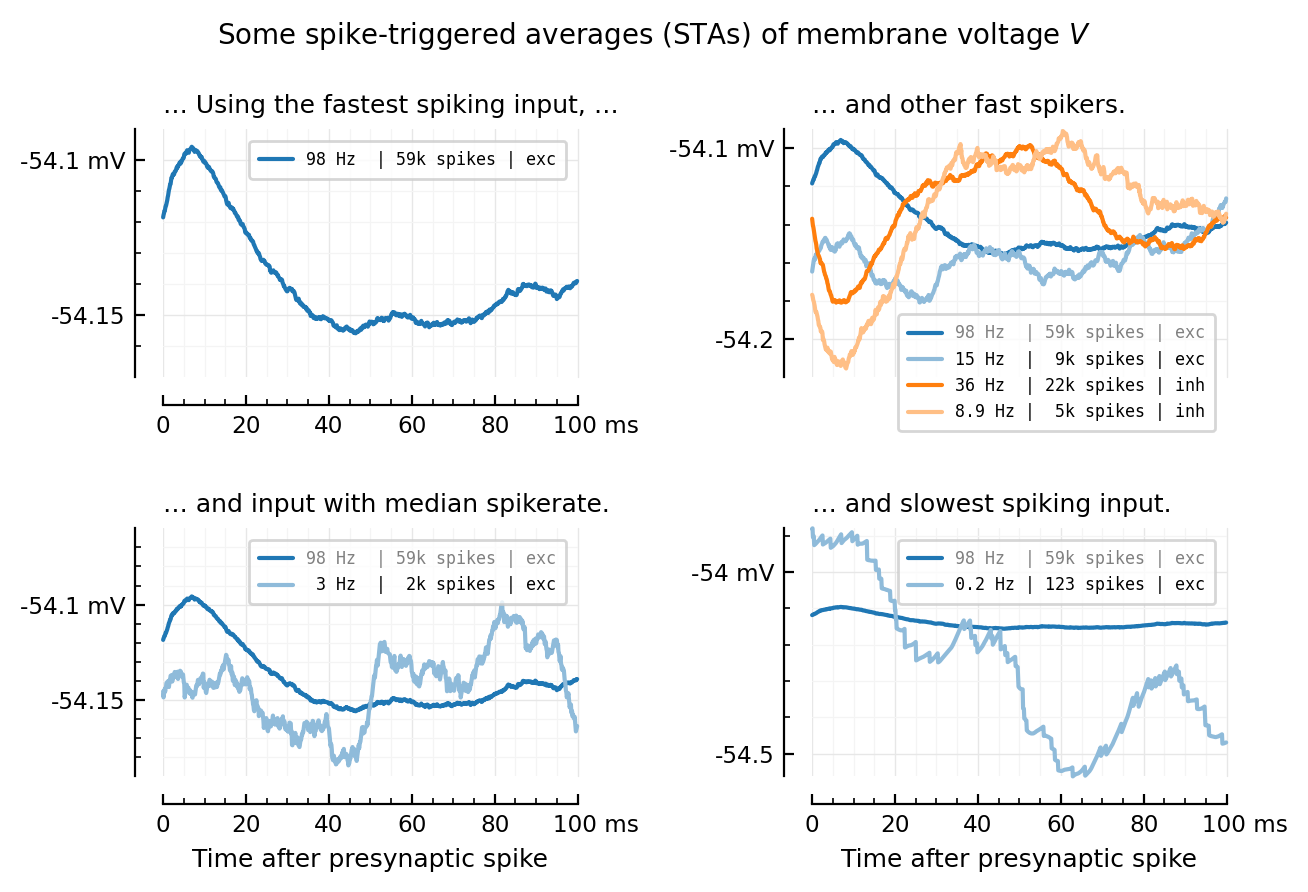

In [524]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(pw*0.8, mtw))

addlegend(ax; kw...) = legend(
    ax, borderaxespad=0.7, prop=Dict("family"=>"monospace", "size"=>6); kw...)

ax = axs[0,0]
plotSTA_(exc_inputs[1]; ax, hylabel="… Using the fastest spiking input, …", xlabel=nothing, ylim=[-54.17, -54.09]);
addlegend(ax)

ax = axs[0,1]
plotSTA_(exc_inputs[1];   ax, color=lighten(color_exc, 1.0), xlabel=nothing, hylabel="… and other fast spikers.")
plotSTA_(exc_inputs[100]; ax, color=lighten(color_exc, 0.5), xlabel=nothing)
plotSTA_(inh_inputs[1];   ax, color=lighten(color_inh, 1.0), xlabel=nothing)
plotSTA_(inh_inputs[100]; ax, color=lighten(color_inh, 0.5), xlabel=nothing, ylim=[-54.22, -54.09])
rm_ticks_and_spine(ax, "bottom")
addlegend(ax, bbox_to_anchor=(1, 0.3), loc="upper right")
deemph_(first(legend_label_texts(ax)))

ax = axs[1,1]
plotSTA_(exc_inputs[1]; ax, hylabel="… and slowest spiking input.")
plotSTA_(exc_inputs[end]; ax, color=lighten(color_exc, 0.5))
addlegend(ax)
deemph_(first(legend_label_texts(ax)))

ax = axs[1,0]
plotSTA_(exc_inputs[1]; ax, hylabel="… and input with median spikerate.")
plotSTA_(exc_inputs[mid]; ax, ylim=[-54.19, -54.06], color=lighten(color_exc, 0.5))
addlegend(ax, loc="upper right")
deemph_(first(legend_label_texts(ax)))

plt.suptitle(L"Some spike-triggered averages (STAs) of membrane voltage $V$", size="medium")

plt.tight_layout(h_pad=2);

savefig_phd("example_STAs")